In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Core PyTorch and TorchVision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Hugging Face timm models
import timm

# Utils
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CUDA available: True
Device name: Tesla P100-PCIE-16GB
Using device: cuda


In [2]:
import json
import os

# 🔹 Enter your Kaggle credentials
kaggle_username = input("Enter your Kaggle username: ")
kaggle_key = input("Enter your Kaggle API key: ")

# Save credentials to kaggle.json
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

# Set proper permissions
os.chmod("/root/.kaggle/kaggle.json", 600)
print("Kaggle API key set successfully ✅")

Enter your Kaggle username:  shraddhaatreya
Enter your Kaggle API key:  d7a68472a232d02050233965ab6187b4


Kaggle API key set successfully ✅


In [3]:
!pip install -q kaggle

# Download datasets from Kaggle (main aksharas + ottaksharas)
!kaggle datasets download -d sahilkumarjamwal/handwritten-kannada-main-aksharas -p /kaggle/working
!kaggle datasets download -d sahilkumarjamwal/handwritten-kannada-ottaksharas -p /kaggle/working

# Unzip datasets
!unzip -qo /kaggle/working/handwritten-kannada-main-aksharas.zip -d /kaggle/working/kannada_main
!unzip -qo /kaggle/working/handwritten-kannada-ottaksharas.zip -d /kaggle/working/kannada_ottaksharas

# Check extraction
print("Main dataset contents:")
!ls /kaggle/working/kannada_main

print("\nOttakshara dataset contents:")
!ls /kaggle/working/kannada_ottaksharas

print("\n✅ Datasets downloaded and extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/sahilkumarjamwal/handwritten-kannada-main-aksharas
License(s): apache-2.0
 97%|██████████████████████████████████████▉ | 358M/368M [00:00<00:00, 1.25GB/s]
100%|████████████████████████████████████████| 368M/368M [00:00<00:00, 1.25GB/s]
Dataset URL: https://www.kaggle.com/datasets/sahilkumarjamwal/handwritten-kannada-ottaksharas
License(s): apache-2.0
  0%|                                               | 0.00/11.1M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 11.1M/11.1M [00:00<00:00, 1.10GB/s]
Main dataset contents:
handwritten-kannada-characters-main

Ottakshara dataset contents:
handwritten-kannada-characters-ottaksharas

✅ Datasets downloaded and extracted successfully!


In [4]:
import os

# Paths where datasets were unzipped
main_path = "/kaggle/working/kannada_main"
ottakshara_path = "/kaggle/working/kannada_ottaksharas"

# Check main dataset structure
print("Main Kannada Aksharas structure:")
print("Top-level folders:", os.listdir(main_path))

# Navigate to the correct character folder
# Adjust this path based on your dataset structure
if 'handwritten-kannada-characters-main' in os.listdir(main_path):
    main_char_path = os.path.join(main_path, 'handwritten-kannada-characters-main')
    if 'Characters' in os.listdir(main_char_path):
        main_char_path = os.path.join(main_char_path, 'Characters')
        print(f"\n✅ Found Characters folder at: {main_char_path}")
        print(f"Number of character classes: {len(os.listdir(main_char_path))}")
        print(f"First 10 classes: {os.listdir(main_char_path)[:10]}")
        
        # Check one class folder
        first_class = os.listdir(main_char_path)[0]
        print(f"\nExample class '{first_class}' contains:")
        print(f"Sample files: {os.listdir(os.path.join(main_char_path, first_class))[:5]}")
        print(f"Total files in this class: {len(os.listdir(os.path.join(main_char_path, first_class)))}")
else:
    print("⚠️ Unexpected folder structure. Please check manually.")
    main_char_path = main_path

# Store the correct path
correct_main_path = main_char_path
print(f"\n✅ Dataset path confirmed: {correct_main_path}")

Main Kannada Aksharas structure:
Top-level folders: ['handwritten-kannada-characters-main']

✅ Found Characters folder at: /kaggle/working/kannada_main/handwritten-kannada-characters-main/Characters
Number of character classes: 588
First 10 classes: ['53', '136', '390', '577', '506', '130', '438', '360', '571', '581']

Example class '53' contains:
Sample files: ['184.jpg', '55.jpg', '227.jpg', '243.jpg', '62.jpg']
Total files in this class: 250

✅ Dataset path confirmed: /kaggle/working/kannada_main/handwritten-kannada-characters-main/Characters


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Data transforms (resize, normalize for ImageNet-pretrained models)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Swin expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the full dataset
dataset = datasets.ImageFolder(root=correct_main_path, transform=train_transform)

# Get targets for stratified split
targets = [s[1] for s in dataset.samples]

# Perform stratified train/validation split (80/20)
train_idx, val_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

# Create subsets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Verify the split
train_targets = [targets[i] for i in train_idx]
val_targets = [targets[i] for i in val_idx]

print("="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Total images: {len(dataset):,}")
print(f"Training images: {len(train_dataset):,}")
print(f"Validation images: {len(val_dataset):,}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Train/Val split: 80% / 20%")
print("-"*70)
print(f"Classes in training set: {len(set(train_targets))}")
print(f"Classes in validation set: {len(set(val_targets))}")
print(f"Avg samples per class: {len(dataset) / len(dataset.classes):.1f}")
print("="*70)
print("✅ Stratified split complete - All classes in both train and val sets!")

DATASET INFORMATION
Total images: 146,556
Training images: 117,244
Validation images: 29,312
Number of classes: 587
Train/Val split: 80% / 20%
----------------------------------------------------------------------
Classes in training set: 587
Classes in validation set: 587
Avg samples per class: 249.7
✅ Stratified split complete - All classes in both train and val sets!


In [6]:
import timm

# Load pretrained Swin Transformer
# Options: 'swin_tiny_patch4_window7_224', 'swin_small_patch4_window7_224', 'swin_base_patch4_window7_224'
model_name = 'swin_tiny_patch4_window7_224'
num_classes = len(dataset.classes)

# Load model with pretrained weights
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

# Move model to GPU
model = model.to(device)

print("="*70)
print("MODEL CONFIGURATION")
print("="*70)
print(f"Model: {model_name}")
print(f"Number of classes: {num_classes}")
print(f"Device: {device}")
print("-"*70)

# Check model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("="*70)
print("✅ Model loaded successfully!")

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

MODEL CONFIGURATION
Model: swin_tiny_patch4_window7_224
Number of classes: 587
Device: cuda
----------------------------------------------------------------------
Total parameters: 27,970,757
Trainable parameters: 27,970,757
✅ Model loaded successfully!


In [7]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (AdamW works well with transformers)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# Learning rate scheduler (cosine annealing)
num_epochs = 5  # 5 epochs for faster training
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: AdamW (lr=1e-4, weight_decay=0.05)")
print(f"Scheduler: CosineAnnealingLR")
print(f"Number of epochs: {num_epochs}")
print(f"Estimated training time: ~2 hours (25 min/epoch)")
print("="*70)
print("✅ Training configuration ready!")

TRAINING CONFIGURATION
Loss function: CrossEntropyLoss
Optimizer: AdamW (lr=1e-4, weight_decay=0.05)
Scheduler: CosineAnnealingLR
Number of epochs: 5
Estimated training time: ~2 hours (25 min/epoch)
✅ Training configuration ready!


In [8]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{running_loss/total:.4f}', 
                         'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': f'{running_loss/total:.4f}', 
                             'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("✅ Training and validation functions defined successfully!")

✅ Training and validation functions defined successfully!


In [9]:
# Training history
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Total epochs: {num_epochs}")
print(f"Estimated time: ~{num_epochs * 25} minutes")
print("="*70 + "\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Step scheduler
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_swin_kannada.pth')
        print(f"✅ Best model saved! (Val Acc: {best_val_acc:.2f}%)")
    
    print("\n")

print("="*70)
print("TRAINING COMPLETED! 🎉")
print("="*70)
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved as: best_swin_kannada.pth")
print("="*70)

STARTING TRAINING
Total epochs: 5
Estimated time: ~125 minutes

Epoch 1/5
--------------------------------------------------


Validation: 100%|██████████| 916/916 [01:24<00:00, 10.85it/s, loss=0.0036, acc=96.56%]



Epoch 1 Summary:
Train Loss: 1.0283 | Train Acc: 80.04%
Val Loss: 0.1167 | Val Acc: 96.56%
Learning Rate: 0.000090
✅ Best model saved! (Val Acc: 96.56%)


Epoch 2/5
--------------------------------------------------


Validation: 100%|██████████| 916/916 [01:24<00:00, 10.82it/s, loss=0.0020, acc=98.06%]



Epoch 2 Summary:
Train Loss: 0.1192 | Train Acc: 96.82%
Val Loss: 0.0636 | Val Acc: 98.06%
Learning Rate: 0.000065
✅ Best model saved! (Val Acc: 98.06%)


Epoch 3/5
--------------------------------------------------


Validation: 100%|██████████| 916/916 [01:24<00:00, 10.84it/s, loss=0.0011, acc=98.71%]



Epoch 3 Summary:
Train Loss: 0.0563 | Train Acc: 98.45%
Val Loss: 0.0365 | Val Acc: 98.71%
Learning Rate: 0.000035
✅ Best model saved! (Val Acc: 98.71%)


Epoch 4/5
--------------------------------------------------


Validation: 100%|██████████| 916/916 [01:24<00:00, 10.83it/s, loss=0.0005, acc=99.48%]



Epoch 4 Summary:
Train Loss: 0.0245 | Train Acc: 99.37%
Val Loss: 0.0163 | Val Acc: 99.48%
Learning Rate: 0.000010
✅ Best model saved! (Val Acc: 99.48%)


Epoch 5/5
--------------------------------------------------


Validation: 100%|██████████| 916/916 [01:24<00:00, 10.87it/s, loss=0.0002, acc=99.80%]



Epoch 5 Summary:
Train Loss: 0.0103 | Train Acc: 99.82%
Val Loss: 0.0059 | Val Acc: 99.80%
Learning Rate: 0.000000
✅ Best model saved! (Val Acc: 99.80%)


TRAINING COMPLETED! 🎉
Best validation accuracy: 99.80%
Model saved as: best_swin_kannada.pth


In [10]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np

print("="*80)
print("CALCULATING PERFORMANCE METRICS")
print("="*80)

# Get predictions on validation set
model.eval()
all_preds = []
all_labels = []

print("\nCollecting predictions from validation set...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate overall metrics
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

# Calculate accuracy
accuracy = 100. * (all_preds == all_labels).sum() / len(all_labels)

print(f"\n{'='*80}")
print(f"PERFORMANCE METRICS - Swin Transformer")
print(f"{'='*80}")
print(f"Validation Accuracy:    {accuracy:.2f}%")
print(f"Weighted Precision:     {precision:.4f}")
print(f"Weighted Recall:        {recall:.4f}")
print(f"Weighted F1-Score:      {f1:.4f}")
print(f"{'='*80}")

# Per-class metrics
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

# Find unique classes
unique_classes = np.unique(all_labels)
print(f"\nClasses in validation set: {len(unique_classes)}")

# Show first 20 classes
print(f"\nPer-Class Metrics (First 20 classes):")
print(f"{'Class ID':<10} {'Class Name':<30} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 94)

for idx, class_id in enumerate(unique_classes[:20]):
    class_name = dataset.classes[class_id][:28]
    print(f"{class_id:<10} {class_name:<30} {precision_per_class[idx]:<12.4f} {recall_per_class[idx]:<12.4f} {f1_per_class[idx]:<12.4f} {support_per_class[idx]:<10}")

# Store metrics
swin_metrics = {
    'model_name': 'Swin Transformer',
    'train_acc': train_accs[-1],
    'val_acc': val_accs[-1],
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1],
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'lr_history': [0.0001 * 0.5 * (1 + np.cos(np.pi * epoch / num_epochs)) for epoch in range(num_epochs)],
    'all_preds': all_preds,
    'all_labels': all_labels
}

print("\n✅ Metrics stored in 'swin_metrics' dictionary")
print("="*80)

CALCULATING PERFORMANCE METRICS



Evaluating: 100%|██████████| 916/916 [01:22<00:00, 11.04it/s]


PERFORMANCE METRICS - Swin Transformer
Validation Accuracy:    99.80%
Weighted Precision:     0.9980
Weighted Recall:        0.9980
Weighted F1-Score:      0.9980

Classes in validation set: 587

Per-Class Metrics (First 20 classes):
Class ID   Class Name                     Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------------------------------
0          0                              1.0000       1.0000       1.0000       50        
1          1                              1.0000       1.0000       1.0000       50        
2          10                             1.0000       1.0000       1.0000       48        
3          100                            1.0000       1.0000       1.0000       50        
4          101                            1.0000       1.0000       1.0000       50        
5          102                            1.0000       1.0000       1.0000       50        
6          103            

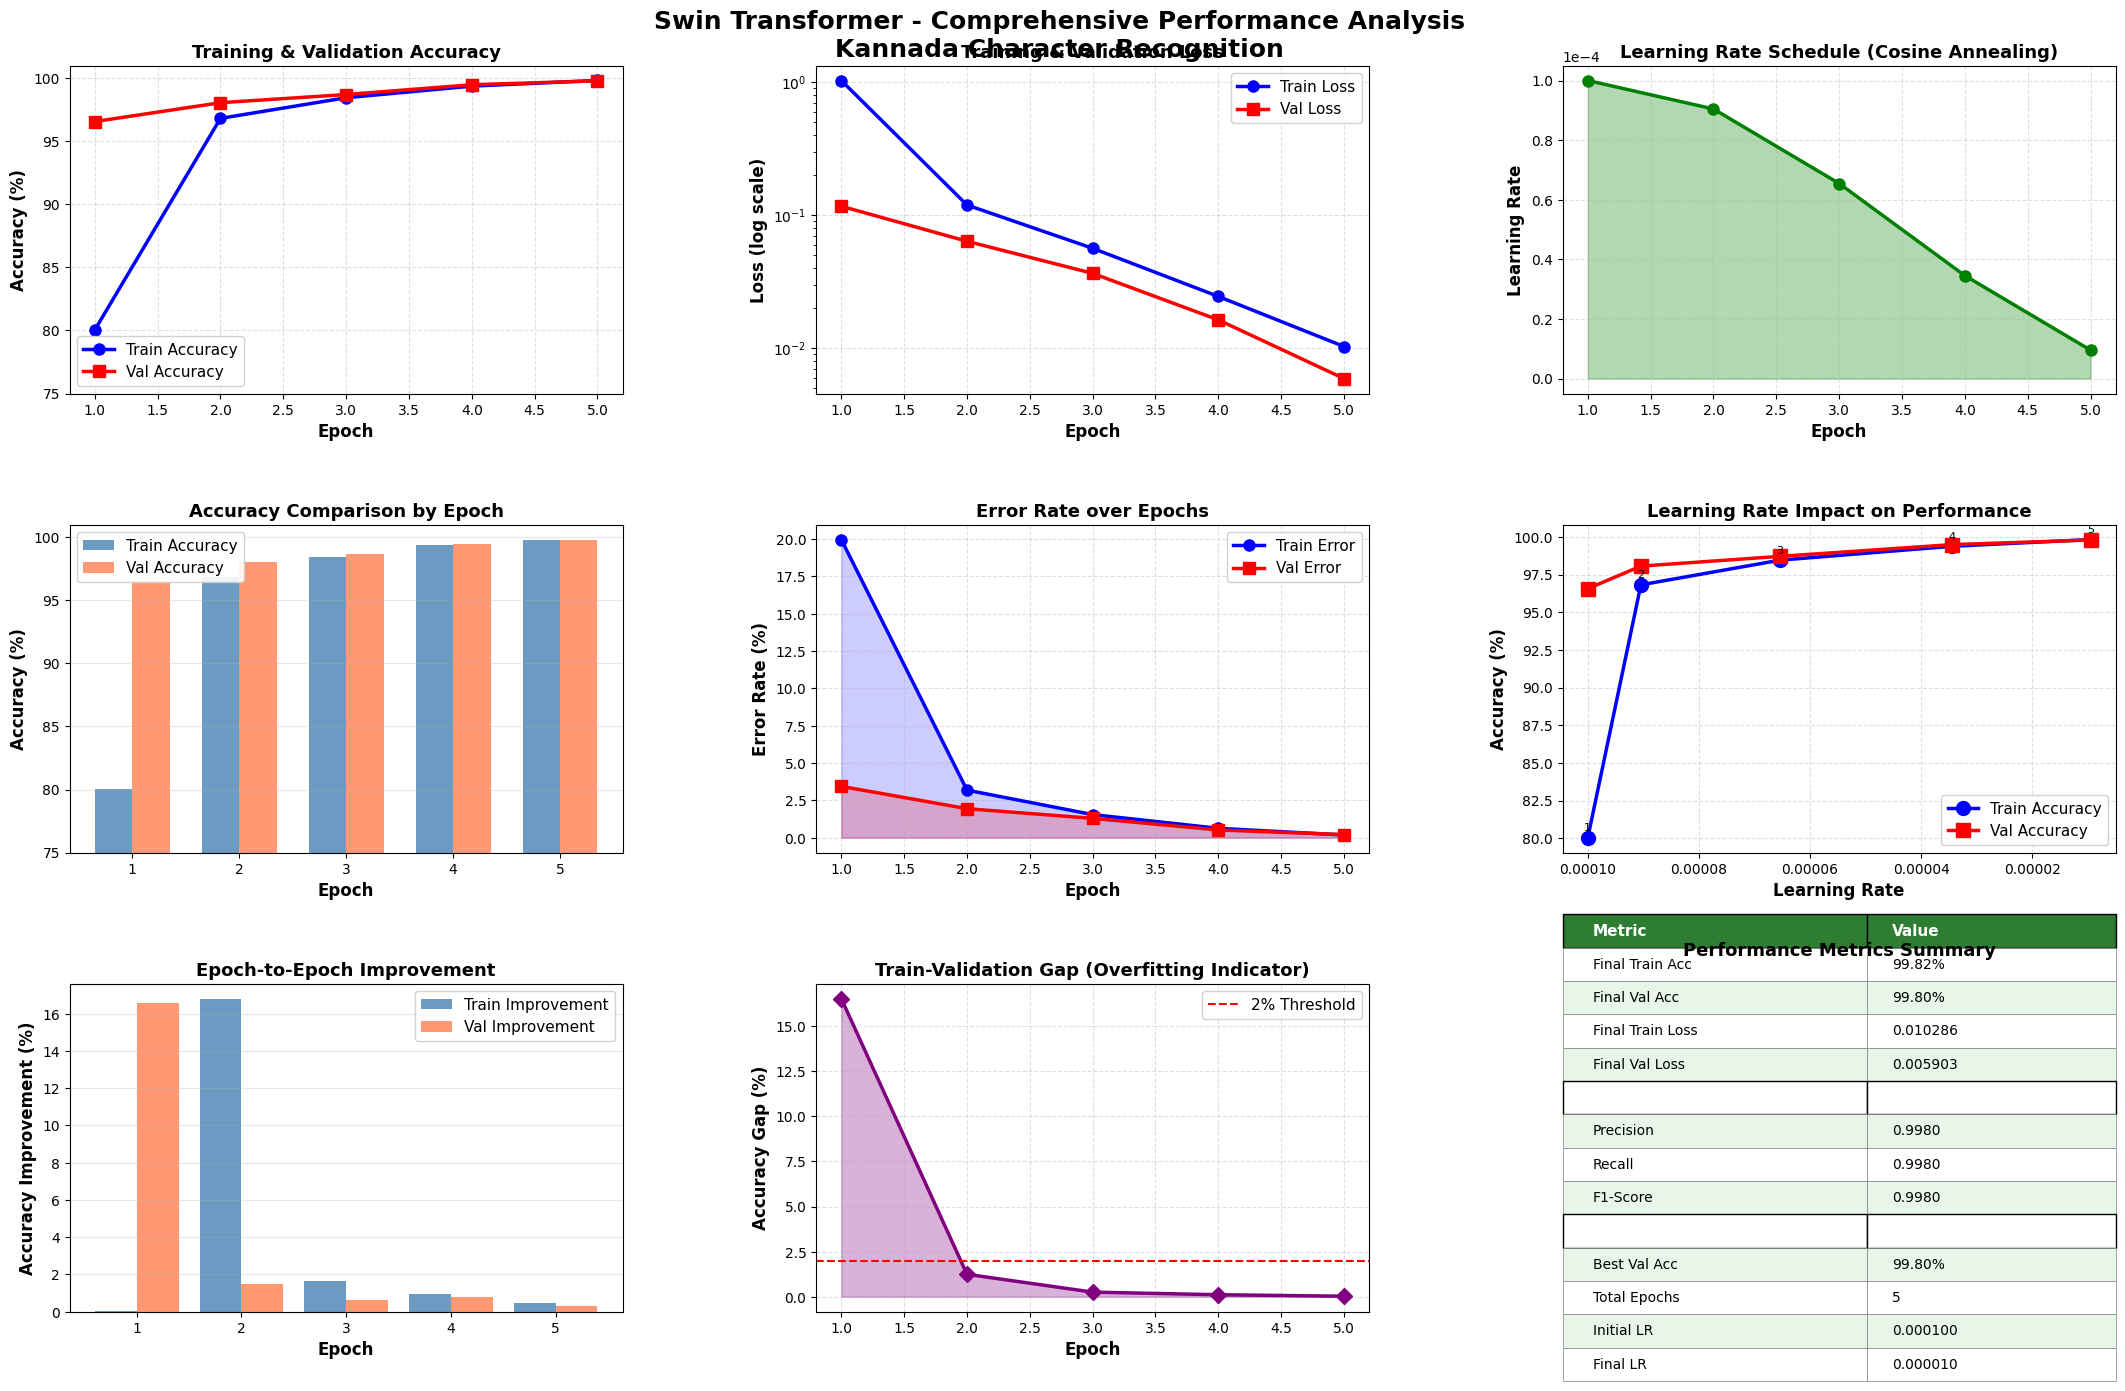


IMPROVED PERFORMANCE ANALYSIS COMPLETE
Visualization saved as 'comprehensive_performance_improved.png'


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive figure with multiple subplots
fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.35, top=0.94, bottom=0.05, left=0.05, right=0.98)

# Get learning rate history and epochs
lr_history = swin_metrics['lr_history']
epochs = range(1, num_epochs + 1)

# ========== Plot 1: Training & Validation Accuracy ==========
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, train_accs, 'b-o', label='Train Accuracy', linewidth=2.5, markersize=8)
ax1.plot(epochs, val_accs, 'r-s', label='Val Accuracy', linewidth=2.5, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Training & Validation Accuracy', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11, framealpha=0.9)
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.set_ylim([75, 101])

# ========== Plot 2: Training & Validation Loss (Log Scale) ==========
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs, train_losses, 'b-o', label='Train Loss', linewidth=2.5, markersize=8)
ax2.plot(epochs, val_losses, 'r-s', label='Val Loss', linewidth=2.5, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss (log scale)', fontsize=12, fontweight='bold')
ax2.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.set_yscale('log')  # Log scale to see the dramatic drop

# ========== Plot 3: Learning Rate Schedule ==========
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(epochs, lr_history, 'g-o', linewidth=2.5, markersize=8)
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax3.set_title('Learning Rate Schedule (Cosine Annealing)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.4, linestyle='--')
ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax3.fill_between(epochs, lr_history, alpha=0.3, color='green')

# ========== Plot 4: Accuracy Progression (Combined) ==========
ax4 = fig.add_subplot(gs[1, 0])
x = np.arange(len(epochs))
width = 0.35
bars1 = ax4.bar(x - width/2, train_accs, width, label='Train Accuracy', color='steelblue', alpha=0.8)
bars2 = ax4.bar(x + width/2, val_accs, width, label='Val Accuracy', color='coral', alpha=0.8)
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax4.set_title('Accuracy Comparison by Epoch', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([f'{i+1}' for i in range(num_epochs)])
ax4.legend(fontsize=11, framealpha=0.9)
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([75, 101])

# ========== Plot 5: Error Rate Progression ==========
ax5 = fig.add_subplot(gs[1, 1])
train_error = [100 - acc for acc in train_accs]
val_error = [100 - acc for acc in val_accs]
ax5.plot(epochs, train_error, 'b-o', label='Train Error', linewidth=2.5, markersize=8)
ax5.plot(epochs, val_error, 'r-s', label='Val Error', linewidth=2.5, markersize=8)
ax5.fill_between(epochs, train_error, alpha=0.2, color='blue')
ax5.fill_between(epochs, val_error, alpha=0.2, color='red')
ax5.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax5.set_ylabel('Error Rate (%)', fontsize=12, fontweight='bold')
ax5.set_title('Error Rate over Epochs', fontsize=13, fontweight='bold')
ax5.legend(fontsize=11, framealpha=0.9)
ax5.grid(True, alpha=0.4, linestyle='--')

# ========== Plot 6: Learning Rate Impact on Accuracy ==========
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(lr_history, train_accs, 'b-o', label='Train Accuracy', linewidth=2.5, markersize=10)
ax6.plot(lr_history, val_accs, 'r-s', label='Val Accuracy', linewidth=2.5, markersize=10)
# Add epoch annotations
for i, (lr, ta, va) in enumerate(zip(lr_history, train_accs, val_accs)):
    ax6.annotate(f'{i+1}', (lr, ta), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
ax6.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax6.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax6.set_title('Learning Rate Impact on Performance', fontsize=13, fontweight='bold')
ax6.legend(fontsize=11, framealpha=0.9)
ax6.grid(True, alpha=0.4, linestyle='--')
ax6.invert_xaxis()  # Higher LR on left

# ========== Plot 7: Convergence Speed ==========
ax7 = fig.add_subplot(gs[2, 0])
improvement_train = [train_accs[i] - train_accs[i-1] if i > 0 else train_accs[0] - 80 for i in range(len(train_accs))]
improvement_val = [val_accs[i] - val_accs[i-1] if i > 0 else val_accs[0] - 80 for i in range(len(val_accs))]
ax7.bar([e - 0.2 for e in epochs], improvement_train, width=0.4, label='Train Improvement', color='steelblue', alpha=0.8)
ax7.bar([e + 0.2 for e in epochs], improvement_val, width=0.4, label='Val Improvement', color='coral', alpha=0.8)
ax7.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax7.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax7.set_ylabel('Accuracy Improvement (%)', fontsize=12, fontweight='bold')
ax7.set_title('Epoch-to-Epoch Improvement', fontsize=13, fontweight='bold')
ax7.legend(fontsize=11, framealpha=0.9)
ax7.grid(True, alpha=0.3, axis='y')

# ========== Plot 8: Train-Val Gap Analysis ==========
ax8 = fig.add_subplot(gs[2, 1])
accuracy_gap = [abs(ta - va) for ta, va in zip(train_accs, val_accs)]
ax8.plot(epochs, accuracy_gap, 'purple', marker='D', linewidth=2.5, markersize=8)
ax8.fill_between(epochs, accuracy_gap, alpha=0.3, color='purple')
ax8.axhline(y=2, color='red', linestyle='--', linewidth=1.5, label='2% Threshold')
ax8.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax8.set_ylabel('Accuracy Gap (%)', fontsize=12, fontweight='bold')
ax8.set_title('Train-Validation Gap (Overfitting Indicator)', fontsize=13, fontweight='bold')
ax8.legend(fontsize=11, framealpha=0.9)
ax8.grid(True, alpha=0.4, linestyle='--')

# ========== Plot 9: Performance Metrics Summary Table ==========
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

metrics_data = [
    ['Metric', 'Value'],
    ['Final Train Acc', f"{train_accs[-1]:.2f}%"],
    ['Final Val Acc', f"{val_accs[-1]:.2f}%"],
    ['Final Train Loss', f"{train_losses[-1]:.6f}"],
    ['Final Val Loss', f"{val_losses[-1]:.6f}"],
    ['', ''],
    ['Precision', f"{swin_metrics['precision']:.4f}"],
    ['Recall', f"{swin_metrics['recall']:.4f}"],
    ['F1-Score', f"{swin_metrics['f1_score']:.4f}"],
    ['', ''],
    ['Best Val Acc', f"{best_val_acc:.2f}%"],
    ['Total Epochs', f"{num_epochs}"],
    ['Initial LR', f"{lr_history[0]:.6f}"],
    ['Final LR', f"{lr_history[-1]:.6f}"],
]

table = ax9.table(cellText=metrics_data, cellLoc='left', loc='center', colWidths=[0.55, 0.45])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.0)

# Enhanced table styling
table[(0, 0)].set_facecolor('#2E7D32')
table[(0, 1)].set_facecolor('#2E7D32')
table[(0, 0)].set_text_props(weight='bold', color='white', size=11)
table[(0, 1)].set_text_props(weight='bold', color='white', size=11)

for i in range(1, len(metrics_data)):
    if metrics_data[i][0] == '':
        continue
    if i % 2 == 0:
        table[(i, 0)].set_facecolor('#E8F5E9')
        table[(i, 1)].set_facecolor('#E8F5E9')
    
    # Add borders
    for j in range(2):
        table[(i, j)].set_edgecolor('gray')
        table[(i, j)].set_linewidth(0.5)

ax9.set_title('Performance Metrics Summary', fontsize=13, fontweight='bold', pad=20)

# Main title
fig.suptitle('Swin Transformer - Comprehensive Performance Analysis\nKannada Character Recognition', 
             fontsize=18, fontweight='bold')

plt.savefig('comprehensive_performance_improved.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("IMPROVED PERFORMANCE ANALYSIS COMPLETE")
print("="*70)
print("Visualization saved as 'comprehensive_performance_improved.png'")
print("="*70)

Generating sample predictions...



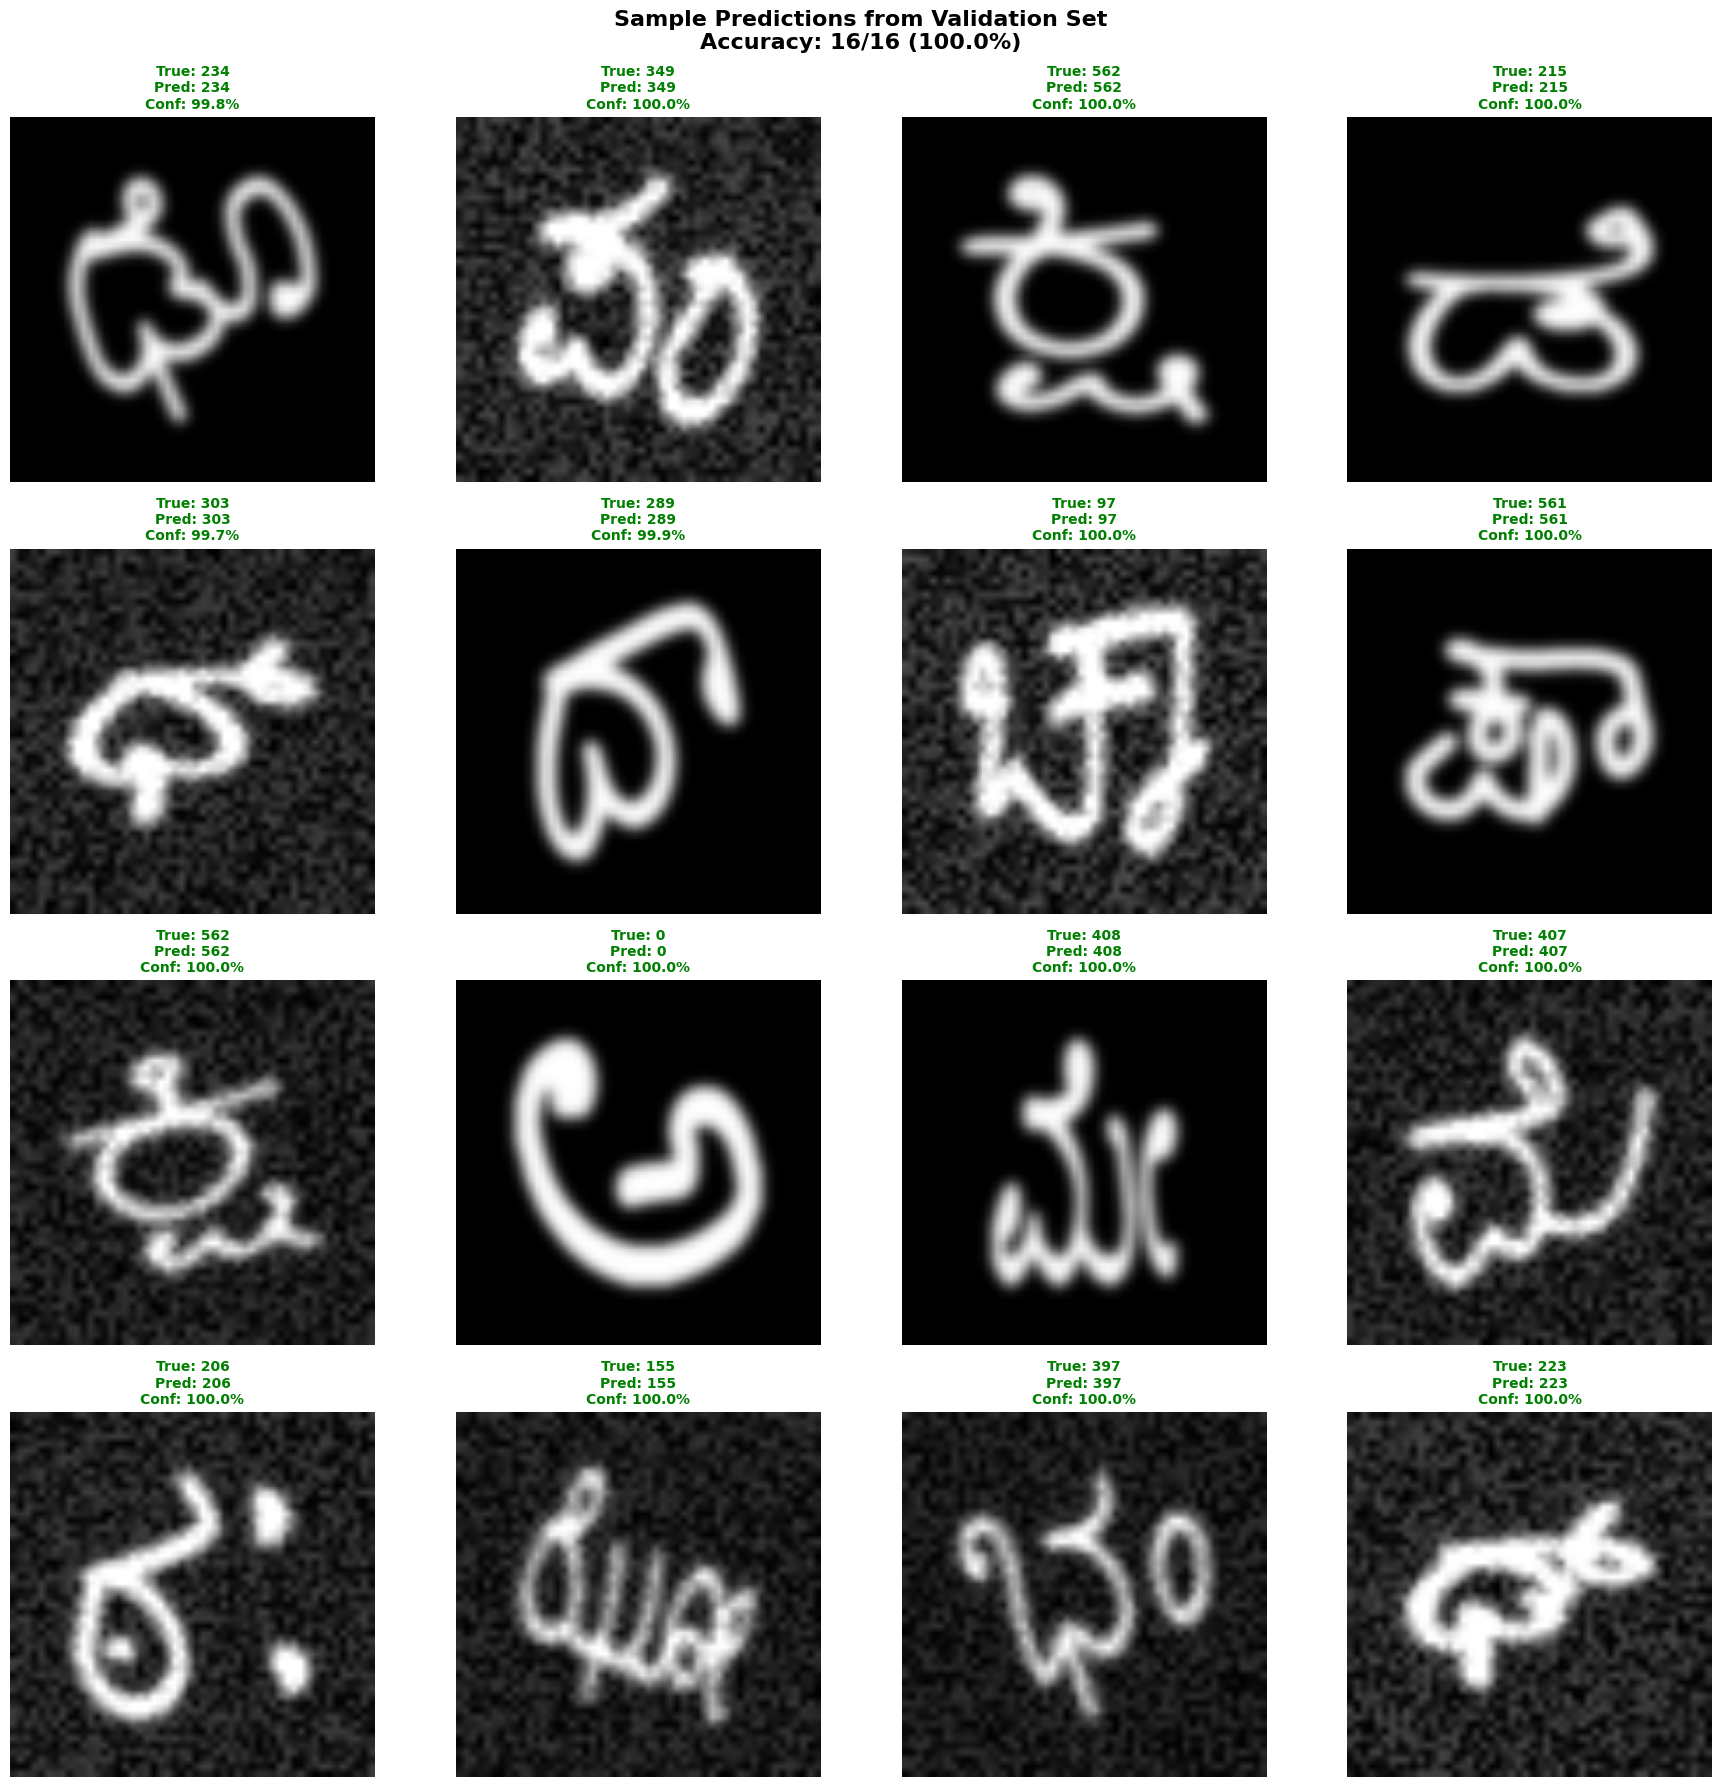


Sample predictions: 16/16 correct (100.0%)


In [12]:
import random
from PIL import Image

def visualize_predictions(model, val_loader, dataset, device, num_samples=16):
    """Visualize predictions using the DataLoader"""
    model.eval()
    
    fig, axes = plt.subplots(4, 4, figsize=(18, 18))
    axes = axes.ravel()
    
    correct_count = 0
    sample_count = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            if sample_count >= num_samples:
                break
                
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            probabilities = torch.softmax(outputs, dim=1)
            
            batch_size = min(images.shape[0], num_samples - sample_count)
            
            for i in range(batch_size):
                if sample_count >= num_samples:
                    break
                
                # Get image, denormalize for display
                img = images[i].cpu()
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = img.clamp(0, 1)
                img = img.permute(1, 2, 0).numpy()
                
                # Get labels and predictions
                true_label = labels[i].item()
                pred_label = predicted[i].item()
                confidence = probabilities[i][pred_label].item() * 100
                
                # Get class names
                true_class_name = dataset.classes[true_label]
                pred_class_name = dataset.classes[pred_label]
                
                # Check if correct
                is_correct = (pred_label == true_label)
                if is_correct:
                    correct_count += 1
                
                # Display
                axes[sample_count].imshow(img)
                axes[sample_count].axis('off')
                
                title_color = 'green' if is_correct else 'red'
                title = f"True: {true_class_name[:15]}\nPred: {pred_class_name[:15]}\nConf: {confidence:.1f}%"
                axes[sample_count].set_title(title, fontsize=10, color=title_color, weight='bold')
                
                sample_count += 1
    
    # Hide unused subplots
    for idx in range(sample_count, 16):
        axes[idx].axis('off')
    
    accuracy = (correct_count / sample_count) * 100
    fig.suptitle(f'Sample Predictions from Validation Set\nAccuracy: {correct_count}/{sample_count} ({accuracy:.1f}%)', 
                 fontsize=16, fontweight='bold', y=0.99)
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{'='*70}")
    print(f"Sample predictions: {correct_count}/{sample_count} correct ({accuracy:.1f}%)")
    print(f"{'='*70}")
    
    return correct_count, sample_count

# Run visualization
print("Generating sample predictions...\n")
correct, total = visualize_predictions(model, val_loader, dataset, device, num_samples=16)

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix (using subset for visualization - all 587 classes would be too large)
cm = confusion_matrix(all_labels, all_preds)

# Find classes with errors
errors = np.where(all_labels != all_preds)[0]
if len(errors) > 0:
    error_classes = np.unique(np.concatenate([all_labels[errors], all_preds[errors]]))
    
    print(f"Total misclassifications: {len(errors)} out of {len(all_labels)} ({len(errors)/len(all_labels)*100:.2f}%)")
    print(f"\nClasses involved in errors: {len(error_classes)}")
    
    # Show some misclassification examples
    print("\nSample Misclassifications:")
    print(f"{'True Class':<15} {'Predicted Class':<15} {'Count':<10}")
    print("-" * 40)
    
    from collections import Counter
    error_pairs = [(all_labels[i], all_preds[i]) for i in errors]
    for (true_class, pred_class), count in Counter(error_pairs).most_common(10):
        true_name = dataset.classes[true_class][:12]
        pred_name = dataset.classes[pred_class][:12]
        print(f"{true_name:<15} {pred_name:<15} {count:<10}")
else:
    print("Perfect classification - No errors to analyze!")

Total misclassifications: 60 out of 29312 (0.20%)

Classes involved in errors: 60

Sample Misclassifications:
True Class      Predicted Class Count     
----------------------------------------
569             567             7         
197             437             5         
567             569             4         
315             314             4         
366             350             3         
76              364             2         
475             123             2         
503             495             2         
508             348             2         
140             12              2         


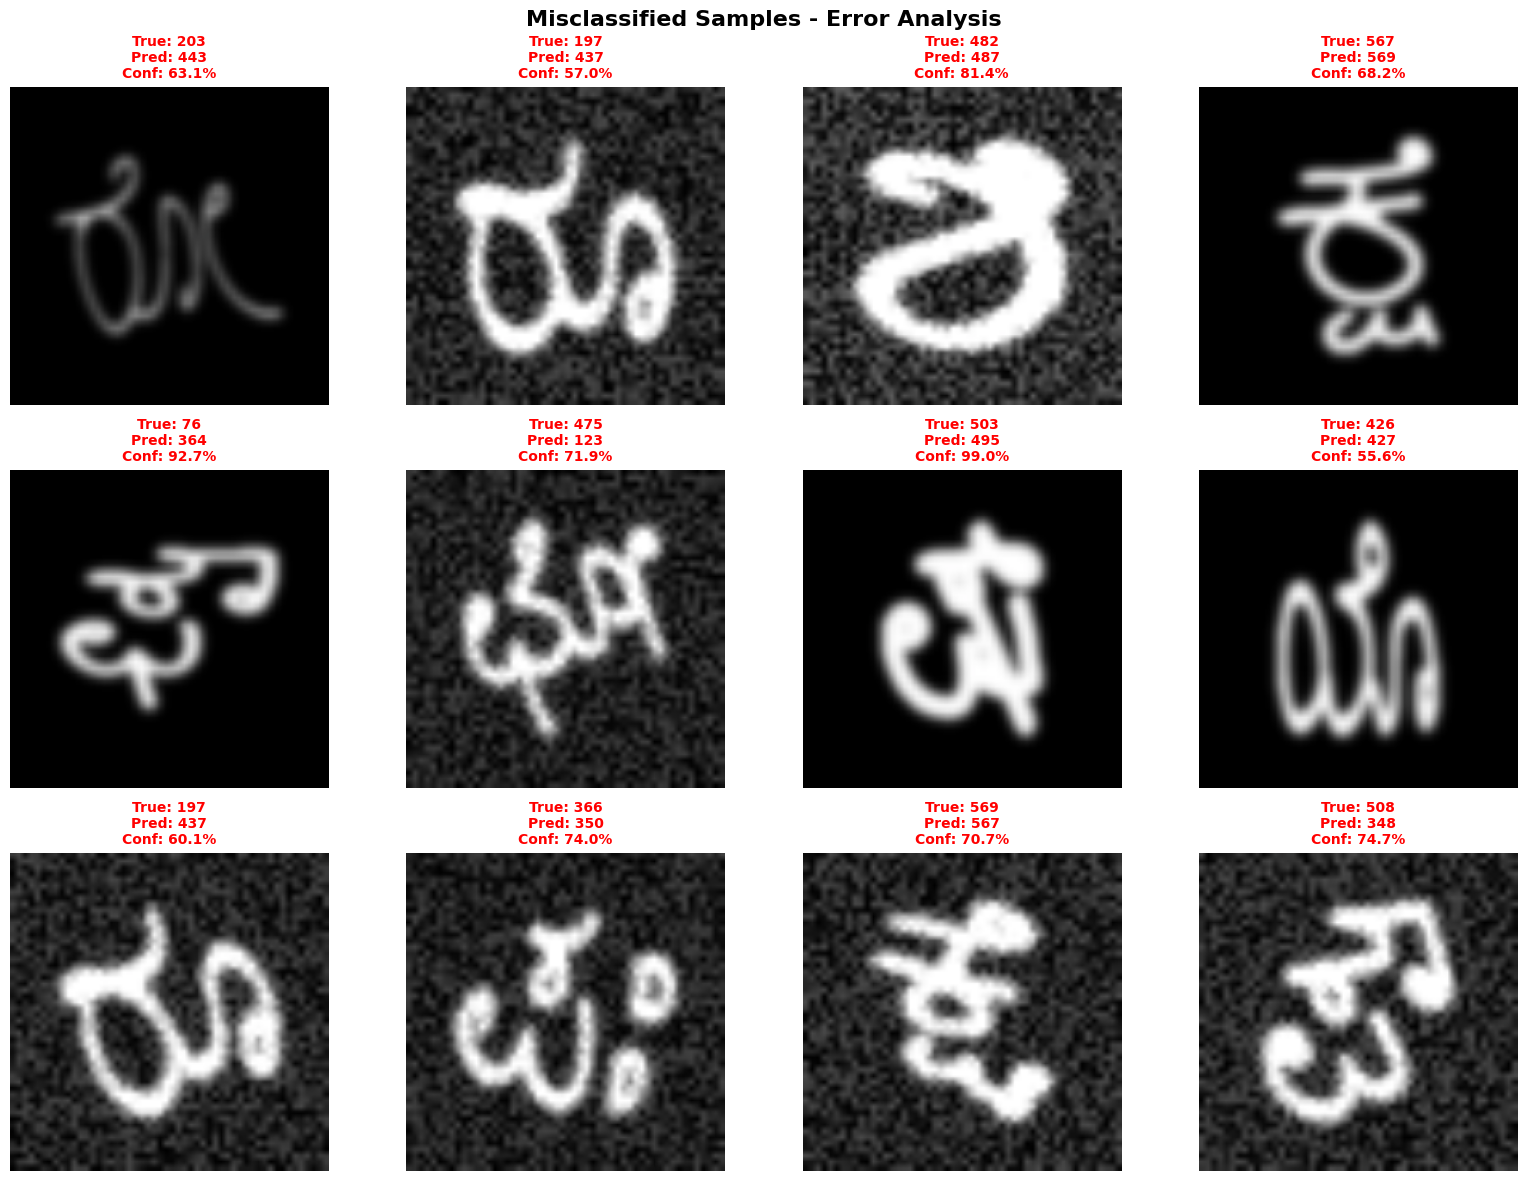

Visualized 12 misclassified samples


In [15]:
# Visualize some misclassified samples to understand errors
def visualize_errors(model, val_loader, dataset, device, num_errors=12):
    """Visualize misclassified samples"""
    model.eval()
    
    errors_found = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            if len(errors_found) >= num_errors:
                break
                
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            probabilities = torch.softmax(outputs, dim=1)
            
            # Find errors in this batch
            for i in range(len(labels)):
                if predicted[i] != labels[i] and len(errors_found) < num_errors:
                    errors_found.append({
                        'image': images[i],
                        'true': labels[i].item(),
                        'pred': predicted[i].item(),
                        'conf': probabilities[i][predicted[i]].item()
                    })
    
    if len(errors_found) == 0:
        print("No errors found to visualize!")
        return
    
    # Plot errors
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    for idx, error in enumerate(errors_found):
        # Denormalize image
        img = error['image'].cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.clamp(0, 1).permute(1, 2, 0).numpy()
        
        true_name = dataset.classes[error['true']]
        pred_name = dataset.classes[error['pred']]
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(
            f"True: {true_name[:12]}\nPred: {pred_name[:12]}\nConf: {error['conf']*100:.1f}%",
            color='red', fontsize=10, fontweight='bold'
        )
    
    fig.suptitle('Misclassified Samples - Error Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('misclassified_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Visualized {len(errors_found)} misclassified samples")

# Run visualization
visualize_errors(model, val_loader, dataset, device, num_errors=12)

Creating confusion matrix visualizations...

Classes with most misclassifications:
Class ID   Class Name                     Total Errors   
-------------------------------------------------------
522        569                            7              
109        197                            5              
241        315                            4              
520        567                            4              
297        366                            3              
450        503                            2              
313        380                            2              
455        508                            2              
569        83                             2              
47         140                            2              


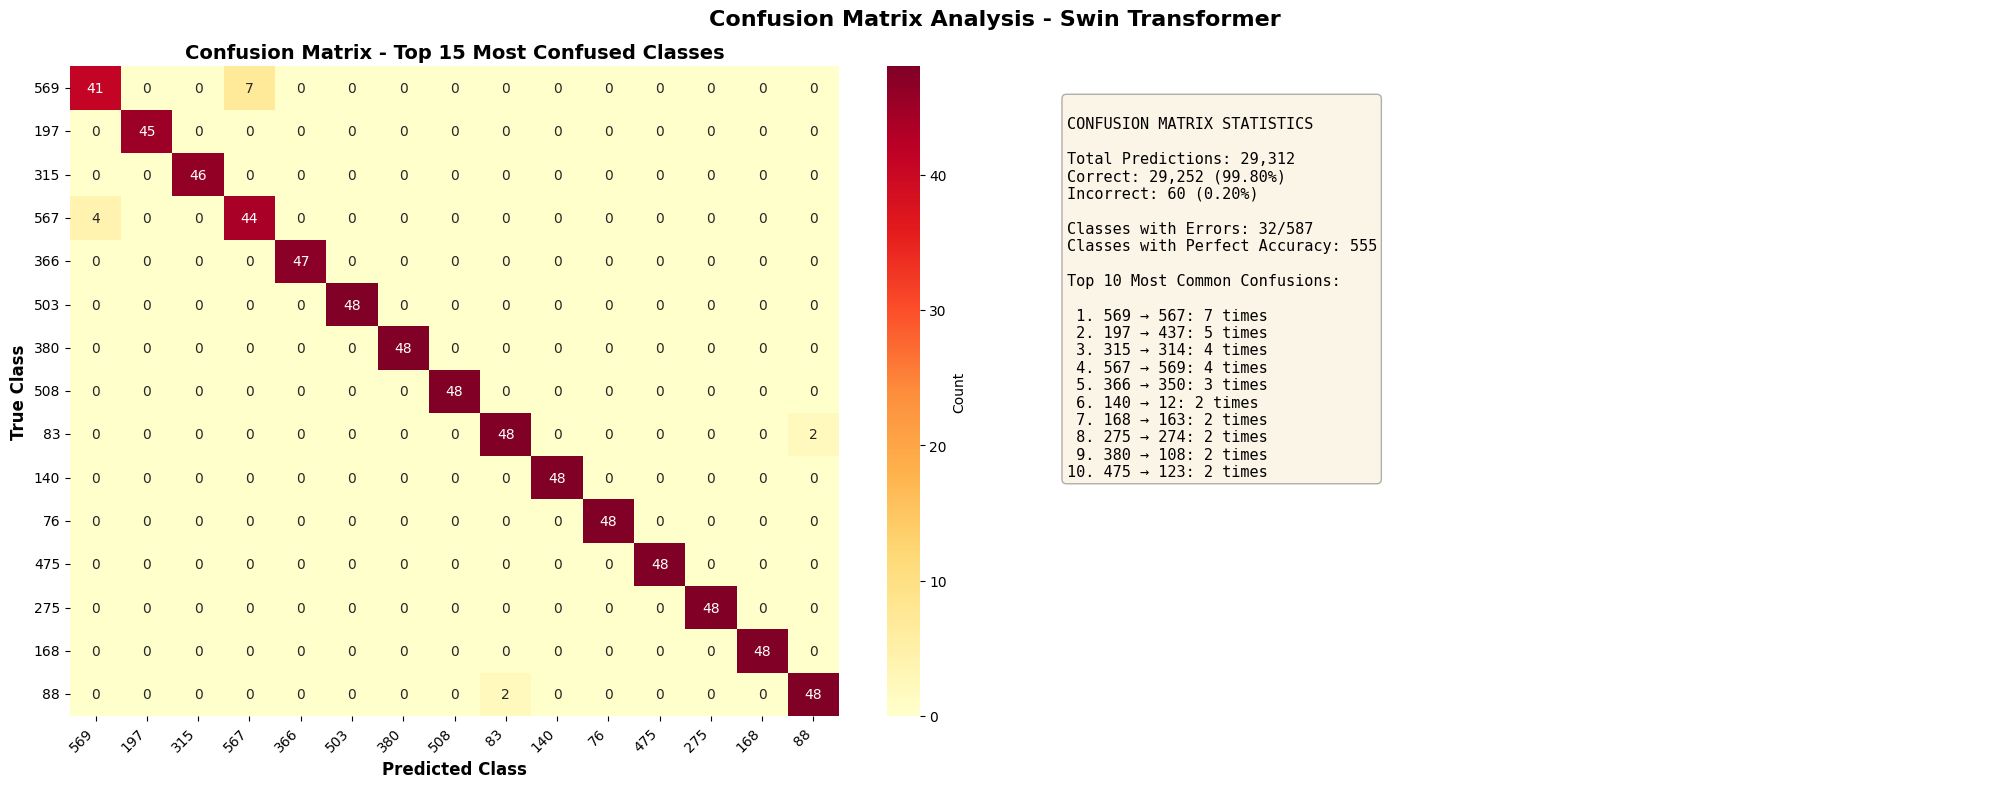


✅ Confusion matrix visualization saved as 'confusion_matrix_analysis.png'


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Since we have 587 classes, a full confusion matrix would be too large to visualize
# Let's create visualizations for the most confused classes

print("Creating confusion matrix visualizations...\n")

# Get the full confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Find classes with the most errors
error_counts = np.sum(cm, axis=1) - np.diag(cm)  # Total errors per class
top_confused_classes = np.argsort(error_counts)[-20:][::-1]  # Top 20 most confused

print(f"Classes with most misclassifications:")
print(f"{'Class ID':<10} {'Class Name':<30} {'Total Errors':<15}")
print("-" * 55)
for class_id in top_confused_classes[:10]:
    if error_counts[class_id] > 0:
        print(f"{class_id:<10} {dataset.classes[class_id][:28]:<30} {error_counts[class_id]:<15}")

# Create a focused confusion matrix for the most problematic classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Confusion matrix for top 15 confused classes
if len(top_confused_classes) > 0 and error_counts[top_confused_classes[0]] > 0:
    confused_subset = top_confused_classes[:15]
    cm_subset = cm[np.ix_(confused_subset, confused_subset)]
    
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='YlOrRd', ax=ax1, 
                xticklabels=[dataset.classes[i][:8] for i in confused_subset],
                yticklabels=[dataset.classes[i][:8] for i in confused_subset],
                cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix - Top 15 Most Confused Classes', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Class', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Class', fontsize=12, fontweight='bold')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax1.get_yticklabels(), rotation=0)
else:
    ax1.text(0.5, 0.5, 'Perfect Classification!\nNo Confusion to Display', 
             ha='center', va='center', fontsize=16, fontweight='bold')
    ax1.axis('off')

# Plot 2: Overall confusion statistics
ax2.axis('off')

# Calculate statistics
total_samples = len(all_labels)
correct = np.sum(all_preds == all_labels)
incorrect = total_samples - correct
accuracy = 100 * correct / total_samples

# Find most common confusions
confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)

stats_text = f"""
CONFUSION MATRIX STATISTICS

Total Predictions: {total_samples:,}
Correct: {correct:,} ({accuracy:.2f}%)
Incorrect: {incorrect:,} ({100-accuracy:.2f}%)

Classes with Errors: {np.sum(error_counts > 0)}/{len(dataset.classes)}
Classes with Perfect Accuracy: {np.sum(error_counts == 0)}

Top 10 Most Common Confusions:
"""

for idx, (true_c, pred_c, count) in enumerate(confusion_pairs[:10], 1):
    true_name = dataset.classes[true_c][:12]
    pred_name = dataset.classes[pred_c][:12]
    stats_text += f"\n{idx:2d}. {true_name} → {pred_name}: {count} times"

ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, 
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Confusion Matrix Analysis - Swin Transformer', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrix visualization saved as 'confusion_matrix_analysis.png'")

COMPLETE METRICS COMPILATION - SWIN TRANSFORMER

📊 PERFORMANCE METRICS SUMMARY:
--------------------------------------------------------------------------------
Metric                         Training                  Validation               
--------------------------------------------------------------------------------
Accuracy                                      99.82%                   99.80%
Precision                                       N/A                  0.9980
Recall                                          N/A                  0.9980
F1-Score                                        N/A                  0.9980
Loss                                       0.010286                0.005903
--------------------------------------------------------------------------------


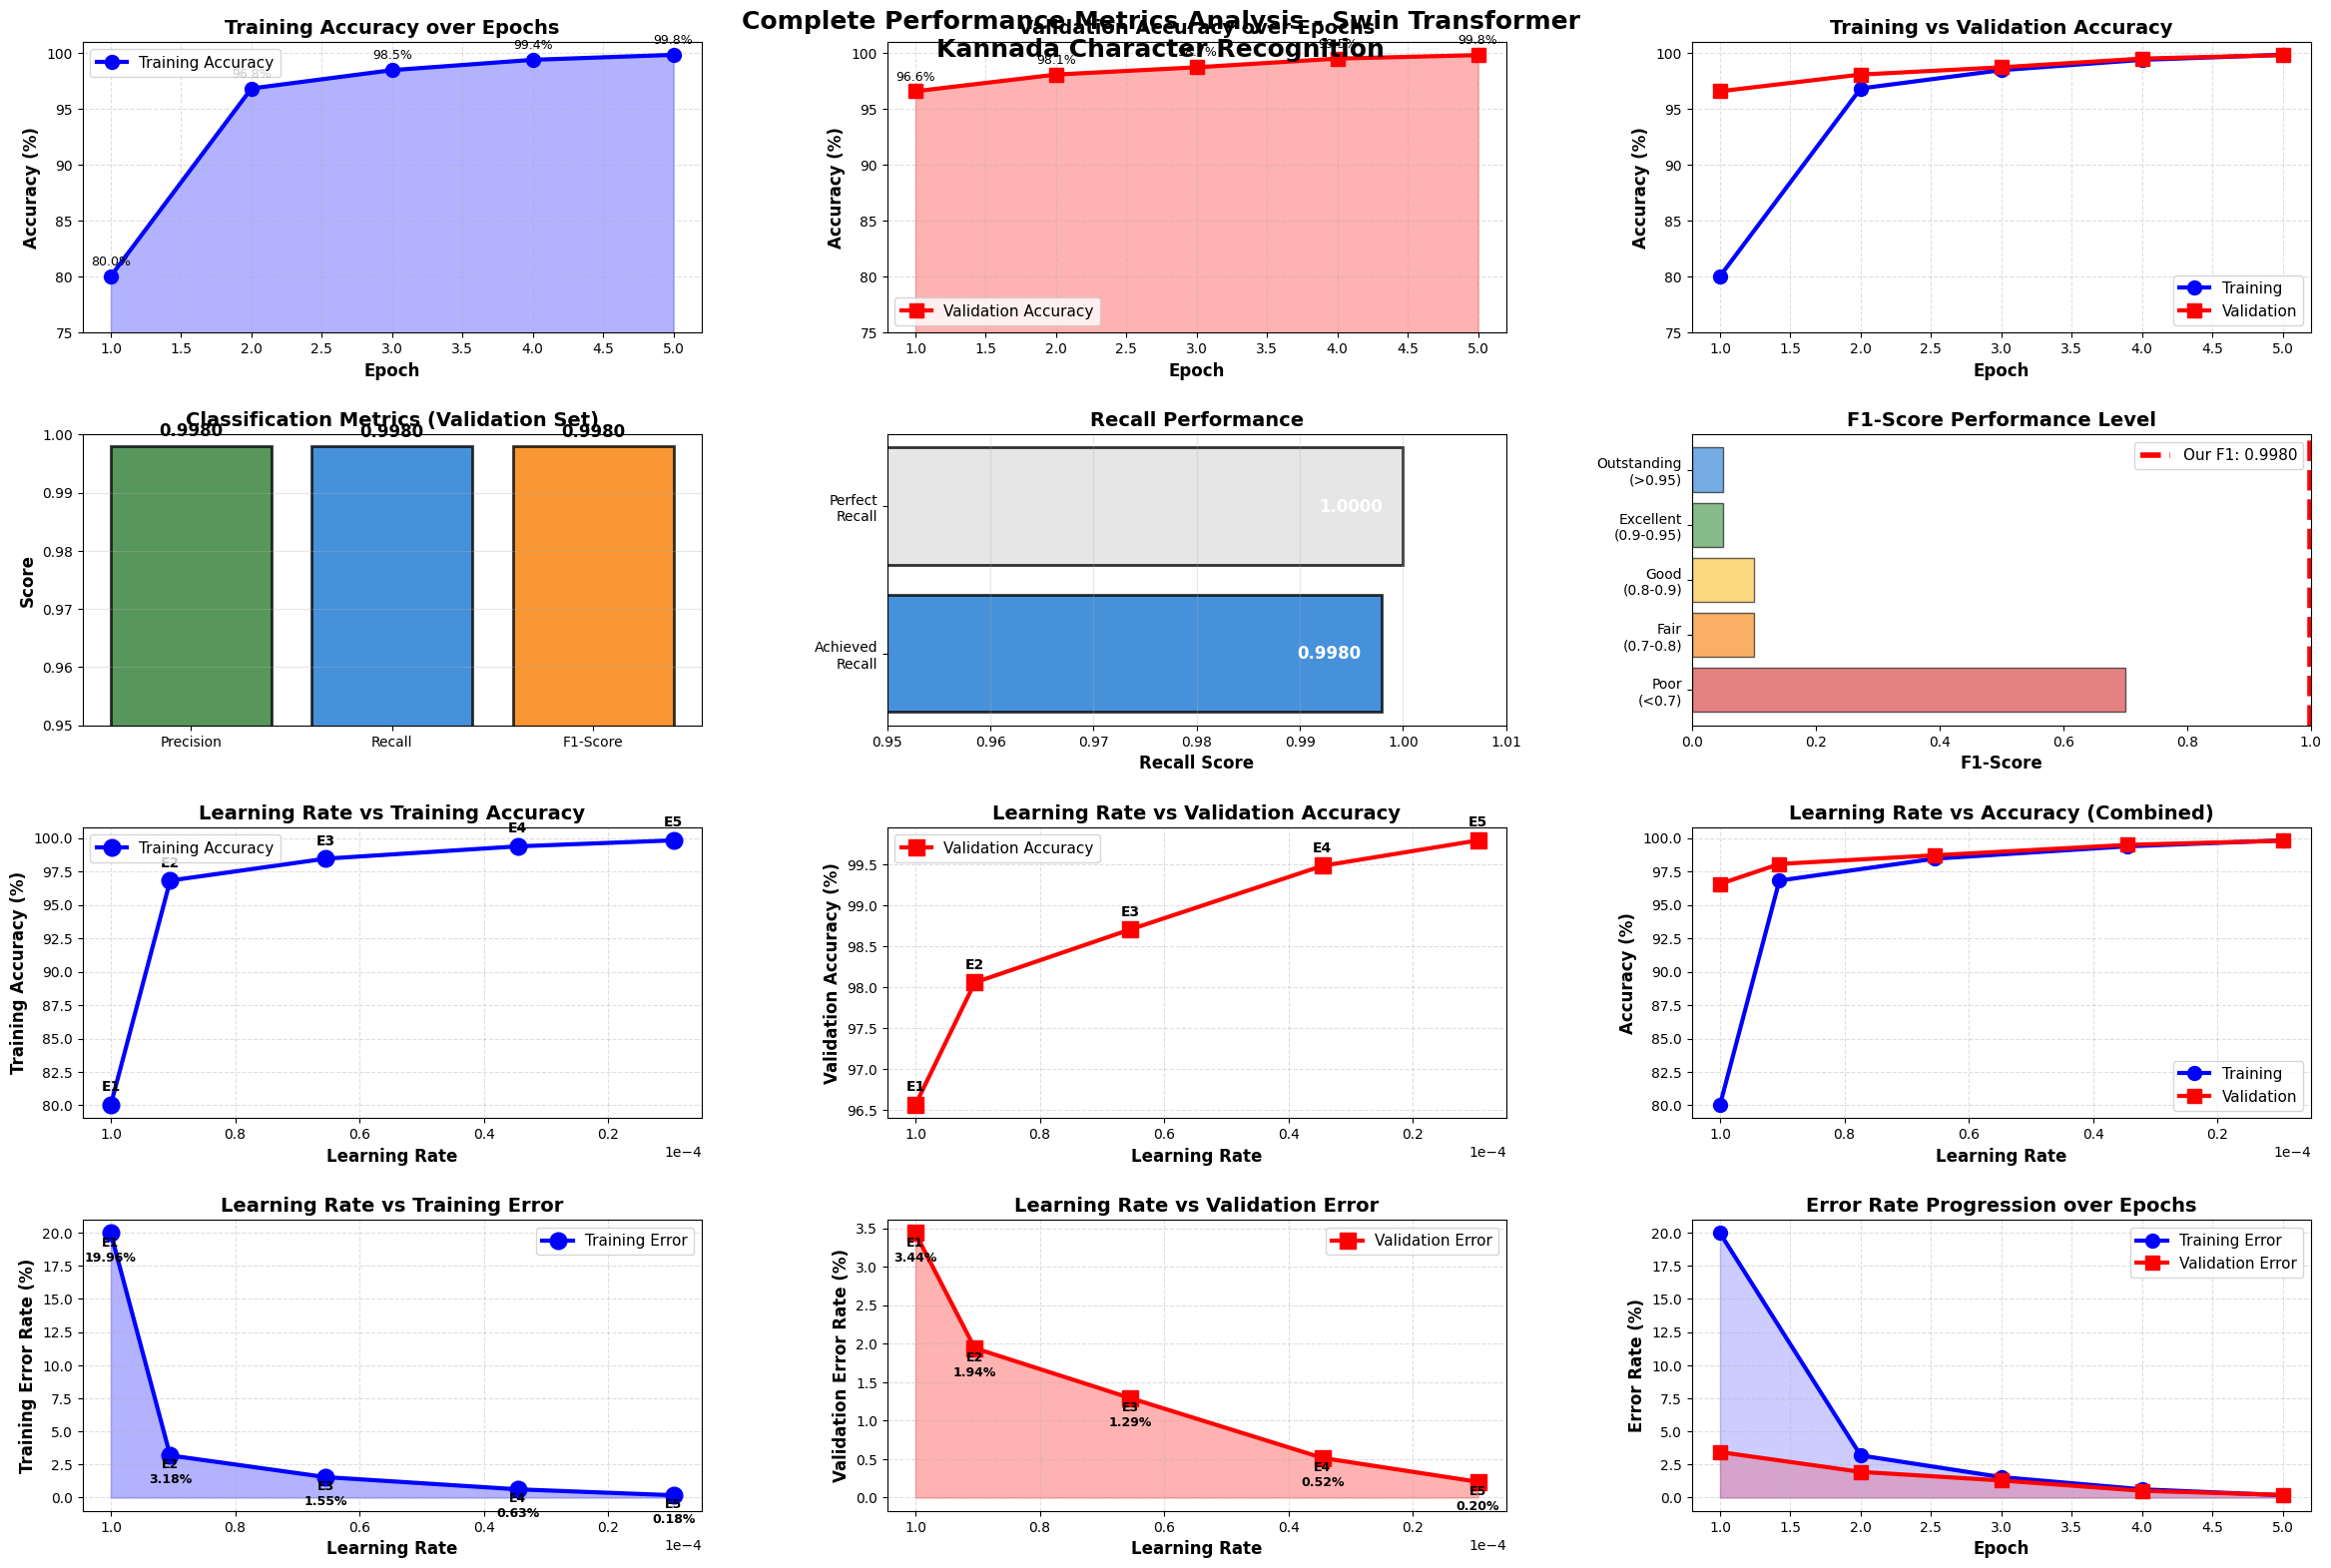


✅ Complete metrics visualization saved as 'complete_metrics_analysis.png'


In [17]:
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("COMPLETE METRICS COMPILATION - SWIN TRANSFORMER")
print("="*80)

# ========== METRICS SUMMARY ==========
print("\n📊 PERFORMANCE METRICS SUMMARY:")
print("-"*80)
print(f"{'Metric':<30} {'Training':<25} {'Validation':<25}")
print("-"*80)
print(f"{'Accuracy':<30} {train_accs[-1]:>20.2f}%    {val_accs[-1]:>20.2f}%")
print(f"{'Precision':<30} {'N/A':>20}    {swin_metrics['precision']:>20.4f}")
print(f"{'Recall':<30} {'N/A':>20}    {swin_metrics['recall']:>20.4f}")
print(f"{'F1-Score':<30} {'N/A':>20}    {swin_metrics['f1_score']:>20.4f}")
print(f"{'Loss':<30} {train_losses[-1]:>20.6f}    {val_losses[-1]:>20.6f}")
print("-"*80)

# ========== CREATE COMPREHENSIVE FIGURE ==========
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3, top=0.96, bottom=0.04, left=0.05, right=0.98)

lr_history = swin_metrics['lr_history']
epochs = range(1, num_epochs + 1)
train_error = [100 - acc for acc in train_accs]
val_error = [100 - acc for acc in val_accs]

# ========== ROW 1: ACCURACY METRICS ==========

# Plot 1: Training Accuracy over Epochs
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, train_accs, 'b-o', linewidth=3, markersize=10, label='Training Accuracy')
ax1.fill_between(epochs, train_accs, alpha=0.3, color='blue')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Training Accuracy over Epochs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.set_ylim([75, 101])
for i, acc in enumerate(train_accs):
    ax1.text(i+1, acc+1, f'{acc:.1f}%', ha='center', fontsize=9)

# Plot 2: Validation Accuracy over Epochs
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs, val_accs, 'r-s', linewidth=3, markersize=10, label='Validation Accuracy')
ax2.fill_between(epochs, val_accs, alpha=0.3, color='red')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.set_ylim([75, 101])
for i, acc in enumerate(val_accs):
    ax2.text(i+1, acc+1, f'{acc:.1f}%', ha='center', fontsize=9)

# Plot 3: Training & Validation Accuracy Combined
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(epochs, train_accs, 'b-o', linewidth=3, markersize=10, label='Training')
ax3.plot(epochs, val_accs, 'r-s', linewidth=3, markersize=10, label='Validation')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax3.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.4, linestyle='--')
ax3.set_ylim([75, 101])

# ========== ROW 2: PRECISION, RECALL, F1-SCORE ==========

# Plot 4: Precision, Recall, F1-Score Bar Chart
ax4 = fig.add_subplot(gs[1, 0])
metrics = ['Precision', 'Recall', 'F1-Score']
values = [swin_metrics['precision'], swin_metrics['recall'], swin_metrics['f1_score']]
colors = ['#2E7D32', '#1976D2', '#F57C00']
bars = ax4.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Classification Metrics (Validation Set)', fontsize=14, fontweight='bold')
ax4.set_ylim([0.95, 1.0])
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 5: Recall Visualization
ax5 = fig.add_subplot(gs[1, 1])
recall_data = [swin_metrics['recall'], 1.0]
labels = ['Achieved\nRecall', 'Perfect\nRecall']
colors_recall = ['#1976D2', '#E0E0E0']
bars = ax5.barh(labels, recall_data, color=colors_recall, alpha=0.8, edgecolor='black', linewidth=2)
ax5.set_xlabel('Recall Score', fontsize=12, fontweight='bold')
ax5.set_title('Recall Performance', fontsize=14, fontweight='bold')
ax5.set_xlim([0.95, 1.01])
ax5.grid(True, alpha=0.3, axis='x')
for bar, val in zip(bars, recall_data):
    width = bar.get_width()
    ax5.text(width - 0.002, bar.get_y() + bar.get_height()/2.,
             f'{val:.4f}', ha='right', va='center', fontsize=12, fontweight='bold', color='white')

# Plot 6: F1-Score Gauge
ax6 = fig.add_subplot(gs[1, 2])
f1_score = swin_metrics['f1_score']
categories = ['Poor\n(<0.7)', 'Fair\n(0.7-0.8)', 'Good\n(0.8-0.9)', 'Excellent\n(0.9-0.95)', 'Outstanding\n(>0.95)']
colors_gauge = ['#D32F2F', '#F57C00', '#FBC02D', '#388E3C', '#1976D2']
ax6.barh(categories, [0.7, 0.1, 0.1, 0.05, 0.05], color=colors_gauge, alpha=0.6, edgecolor='black')
ax6.axvline(x=f1_score, color='red', linewidth=4, linestyle='--', label=f'Our F1: {f1_score:.4f}')
ax6.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax6.set_title('F1-Score Performance Level', fontsize=14, fontweight='bold')
ax6.legend(fontsize=11)
ax6.set_xlim([0, 1.0])

# ========== ROW 3: LEARNING RATE ANALYSIS ==========

# Plot 7: Learning Rate vs Training Accuracy
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(lr_history, train_accs, 'b-o', linewidth=3, markersize=12, label='Training Accuracy')
for i, (lr, acc) in enumerate(zip(lr_history, train_accs)):
    ax7.annotate(f'E{i+1}', (lr, acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10, fontweight='bold')
ax7.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax7.set_ylabel('Training Accuracy (%)', fontsize=12, fontweight='bold')
ax7.set_title('Learning Rate vs Training Accuracy', fontsize=14, fontweight='bold')
ax7.legend(fontsize=11)
ax7.grid(True, alpha=0.4, linestyle='--')
ax7.invert_xaxis()
ax7.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 8: Learning Rate vs Validation Accuracy
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(lr_history, val_accs, 'r-s', linewidth=3, markersize=12, label='Validation Accuracy')
for i, (lr, acc) in enumerate(zip(lr_history, val_accs)):
    ax8.annotate(f'E{i+1}', (lr, acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10, fontweight='bold')
ax8.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax8.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax8.set_title('Learning Rate vs Validation Accuracy', fontsize=14, fontweight='bold')
ax8.legend(fontsize=11)
ax8.grid(True, alpha=0.4, linestyle='--')
ax8.invert_xaxis()
ax8.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 9: Learning Rate vs Both Accuracies
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(lr_history, train_accs, 'b-o', linewidth=3, markersize=10, label='Training')
ax9.plot(lr_history, val_accs, 'r-s', linewidth=3, markersize=10, label='Validation')
ax9.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax9.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax9.set_title('Learning Rate vs Accuracy (Combined)', fontsize=14, fontweight='bold')
ax9.legend(fontsize=11)
ax9.grid(True, alpha=0.4, linestyle='--')
ax9.invert_xaxis()
ax9.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# ========== ROW 4: ERROR RATE ANALYSIS ==========

# Plot 10: Learning Rate vs Training Error
ax10 = fig.add_subplot(gs[3, 0])
ax10.plot(lr_history, train_error, 'b-o', linewidth=3, markersize=12, label='Training Error')
ax10.fill_between(lr_history, train_error, alpha=0.3, color='blue')
for i, (lr, err) in enumerate(zip(lr_history, train_error)):
    ax10.annotate(f'E{i+1}\n{err:.2f}%', (lr, err), textcoords="offset points", 
                 xytext=(0,-20), ha='center', fontsize=9, fontweight='bold')
ax10.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax10.set_ylabel('Training Error Rate (%)', fontsize=12, fontweight='bold')
ax10.set_title('Learning Rate vs Training Error', fontsize=14, fontweight='bold')
ax10.legend(fontsize=11)
ax10.grid(True, alpha=0.4, linestyle='--')
ax10.invert_xaxis()
ax10.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 11: Learning Rate vs Validation Error
ax11 = fig.add_subplot(gs[3, 1])
ax11.plot(lr_history, val_error, 'r-s', linewidth=3, markersize=12, label='Validation Error')
ax11.fill_between(lr_history, val_error, alpha=0.3, color='red')
for i, (lr, err) in enumerate(zip(lr_history, val_error)):
    ax11.annotate(f'E{i+1}\n{err:.2f}%', (lr, err), textcoords="offset points", 
                 xytext=(0,-20), ha='center', fontsize=9, fontweight='bold')
ax11.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
ax11.set_ylabel('Validation Error Rate (%)', fontsize=12, fontweight='bold')
ax11.set_title('Learning Rate vs Validation Error', fontsize=14, fontweight='bold')
ax11.legend(fontsize=11)
ax11.grid(True, alpha=0.4, linestyle='--')
ax11.invert_xaxis()
ax11.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 12: Error Rate over Epochs
ax12 = fig.add_subplot(gs[3, 2])
ax12.plot(epochs, train_error, 'b-o', linewidth=3, markersize=10, label='Training Error')
ax12.plot(epochs, val_error, 'r-s', linewidth=3, markersize=10, label='Validation Error')
ax12.fill_between(epochs, train_error, alpha=0.2, color='blue')
ax12.fill_between(epochs, val_error, alpha=0.2, color='red')
ax12.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax12.set_ylabel('Error Rate (%)', fontsize=12, fontweight='bold')
ax12.set_title('Error Rate Progression over Epochs', fontsize=14, fontweight='bold')
ax12.legend(fontsize=11)
ax12.grid(True, alpha=0.4, linestyle='--')

# Main title
fig.suptitle('Complete Performance Metrics Analysis - Swin Transformer\nKannada Character Recognition', 
             fontsize=18, fontweight='bold')

plt.savefig('complete_metrics_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Complete metrics visualization saved as 'complete_metrics_analysis.png'")
print("="*80)

Loading existing t-SNE results...

Visualizing top 50 classes by sample count:
Total samples in visualization: 693


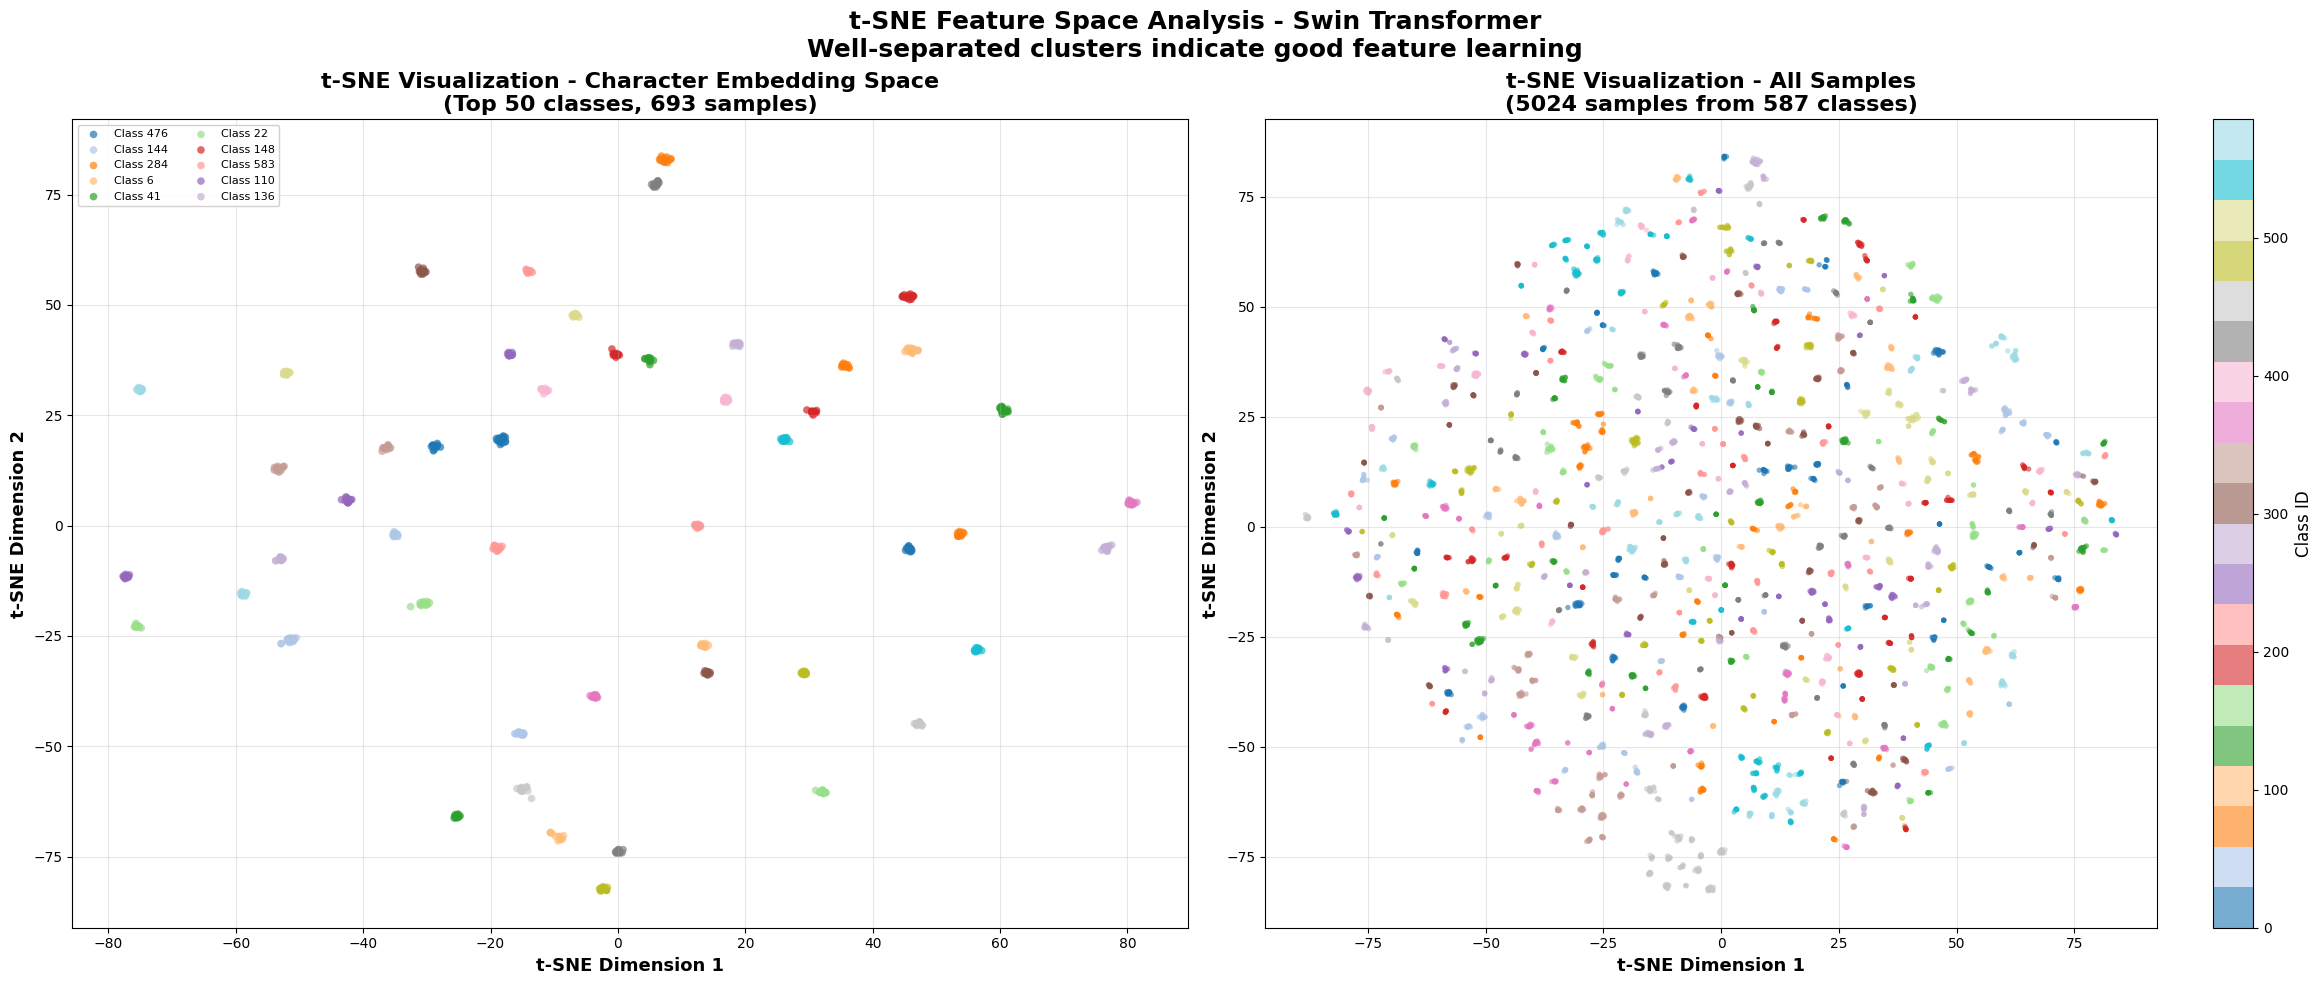


t-SNE ANALYSIS SUMMARY
Total samples visualized: 5024
Total unique classes: 587
Samples per class (avg): 8.6

Top 5 most represented classes:
  1. Class 476 (527): 19 samples
  2. Class 144 (228): 18 samples
  3. Class 284 (354): 17 samples
  4. Class 6 (103): 17 samples
  5. Class 41 (135): 16 samples

Average centroid separation: 69.56
(Higher values indicate better class separation)

Visualization saved as 'tsne_fixed_visualization.png'


In [19]:
from sklearn.manifold import TSNE

# Check if t-SNE was already done
if 'tsne_results' not in swin_metrics:
    print("Creating t-SNE visualization...")
    
    # Extract features from the model (before final classification layer)
    def get_features(model, loader, device, max_samples=5000):
        """Extract features from second-to-last layer"""
        model.eval()
        features_list = []
        labels_list = []
        
        # Remove classification head to get features
        feature_extractor = nn.Sequential(*list(model.children())[:-1])
        
        print(f"Extracting features (max {max_samples} samples)...")
        with torch.no_grad():
            for images, labels in tqdm(loader):
                if len(features_list) * loader.batch_size >= max_samples:
                    break
                    
                images = images.to(device)
                features = feature_extractor(images)
                features = features.view(features.size(0), -1)
                
                features_list.append(features.cpu().numpy())
                labels_list.append(labels.numpy())
        
        features = np.vstack(features_list)
        labels = np.concatenate(labels_list)
        return features, labels
    
    # Extract features
    val_features, val_labels = get_features(model, val_loader, device, max_samples=5000)
    
    print(f"\nFeature shape: {val_features.shape}")
    print(f"Running t-SNE (this may take a few minutes)...")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
    tsne_results = tsne.fit_transform(val_features)
    
    # Store results
    swin_metrics['tsne_results'] = tsne_results
    swin_metrics['tsne_labels'] = val_labels
    
    print("t-SNE completed!")
else:
    print("Loading existing t-SNE results...")
    tsne_results = swin_metrics['tsne_results']
    val_labels = swin_metrics['tsne_labels']

# Create improved t-SNE visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Get class distribution
unique_labels = np.unique(val_labels)
n_classes = len(unique_labels)

# Count samples per class
from collections import Counter
class_counts = Counter(val_labels)

# Find classes with most samples for visualization
top_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:50]
top_class_ids = [c[0] for c in top_classes]

print(f"\nVisualizing top 50 classes by sample count:")
print(f"Total samples in visualization: {sum([class_counts[c] for c in top_class_ids])}")

# Plot 1: t-SNE with top 50 most represented classes
colors = plt.cm.tab20(np.linspace(0, 1, 20))
colors = np.vstack([colors] * 3)  # Repeat colors for 50 classes

points_plotted = 0
for idx, class_id in enumerate(top_class_ids):
    mask = val_labels == class_id
    color = colors[idx % len(colors)]
    ax1.scatter(tsne_results[mask, 0], tsne_results[mask, 1], 
               c=[color], s=30, alpha=0.7, edgecolors='none',
               label=f'Class {class_id}' if idx < 10 else '')
    points_plotted += mask.sum()

ax1.set_title(f't-SNE Visualization - Character Embedding Space\n(Top 50 classes, {points_plotted} samples)', 
             fontsize=16, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax1.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=8, ncol=2, framealpha=0.9)

# Plot 2: ALL points colored by class ID
scatter = ax2.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                     c=val_labels, cmap='tab20', s=15, alpha=0.6, edgecolors='none')
ax2.set_title(f't-SNE Visualization - All Samples\n({len(tsne_results)} samples from {n_classes} classes)', 
             fontsize=16, fontweight='bold')
ax2.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax2.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Class ID', fontsize=12)

plt.suptitle('t-SNE Feature Space Analysis - Swin Transformer\nWell-separated clusters indicate good feature learning', 
             fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('tsne_fixed_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis
print("\n" + "="*80)
print("t-SNE ANALYSIS SUMMARY")
print("="*80)
print(f"Total samples visualized: {len(tsne_results)}")
print(f"Total unique classes: {n_classes}")
print(f"Samples per class (avg): {len(tsne_results) / n_classes:.1f}")
print(f"\nTop 5 most represented classes:")
for i, (class_id, count) in enumerate(top_classes[:5], 1):
    print(f"  {i}. Class {class_id} ({dataset.classes[class_id][:20]}): {count} samples")

# Calculate separation metric (average distance between class centroids)
centroids = {}
for class_id in unique_labels:
    mask = val_labels == class_id
    if mask.sum() > 0:
        centroids[class_id] = tsne_results[mask].mean(axis=0)

centroid_positions = np.array(list(centroids.values()))
from scipy.spatial.distance import pdist
avg_separation = pdist(centroid_positions).mean()

print(f"\nAverage centroid separation: {avg_separation:.2f}")
print("(Higher values indicate better class separation)")
print("="*80)
print("\nVisualization saved as 'tsne_fixed_visualization.png'")

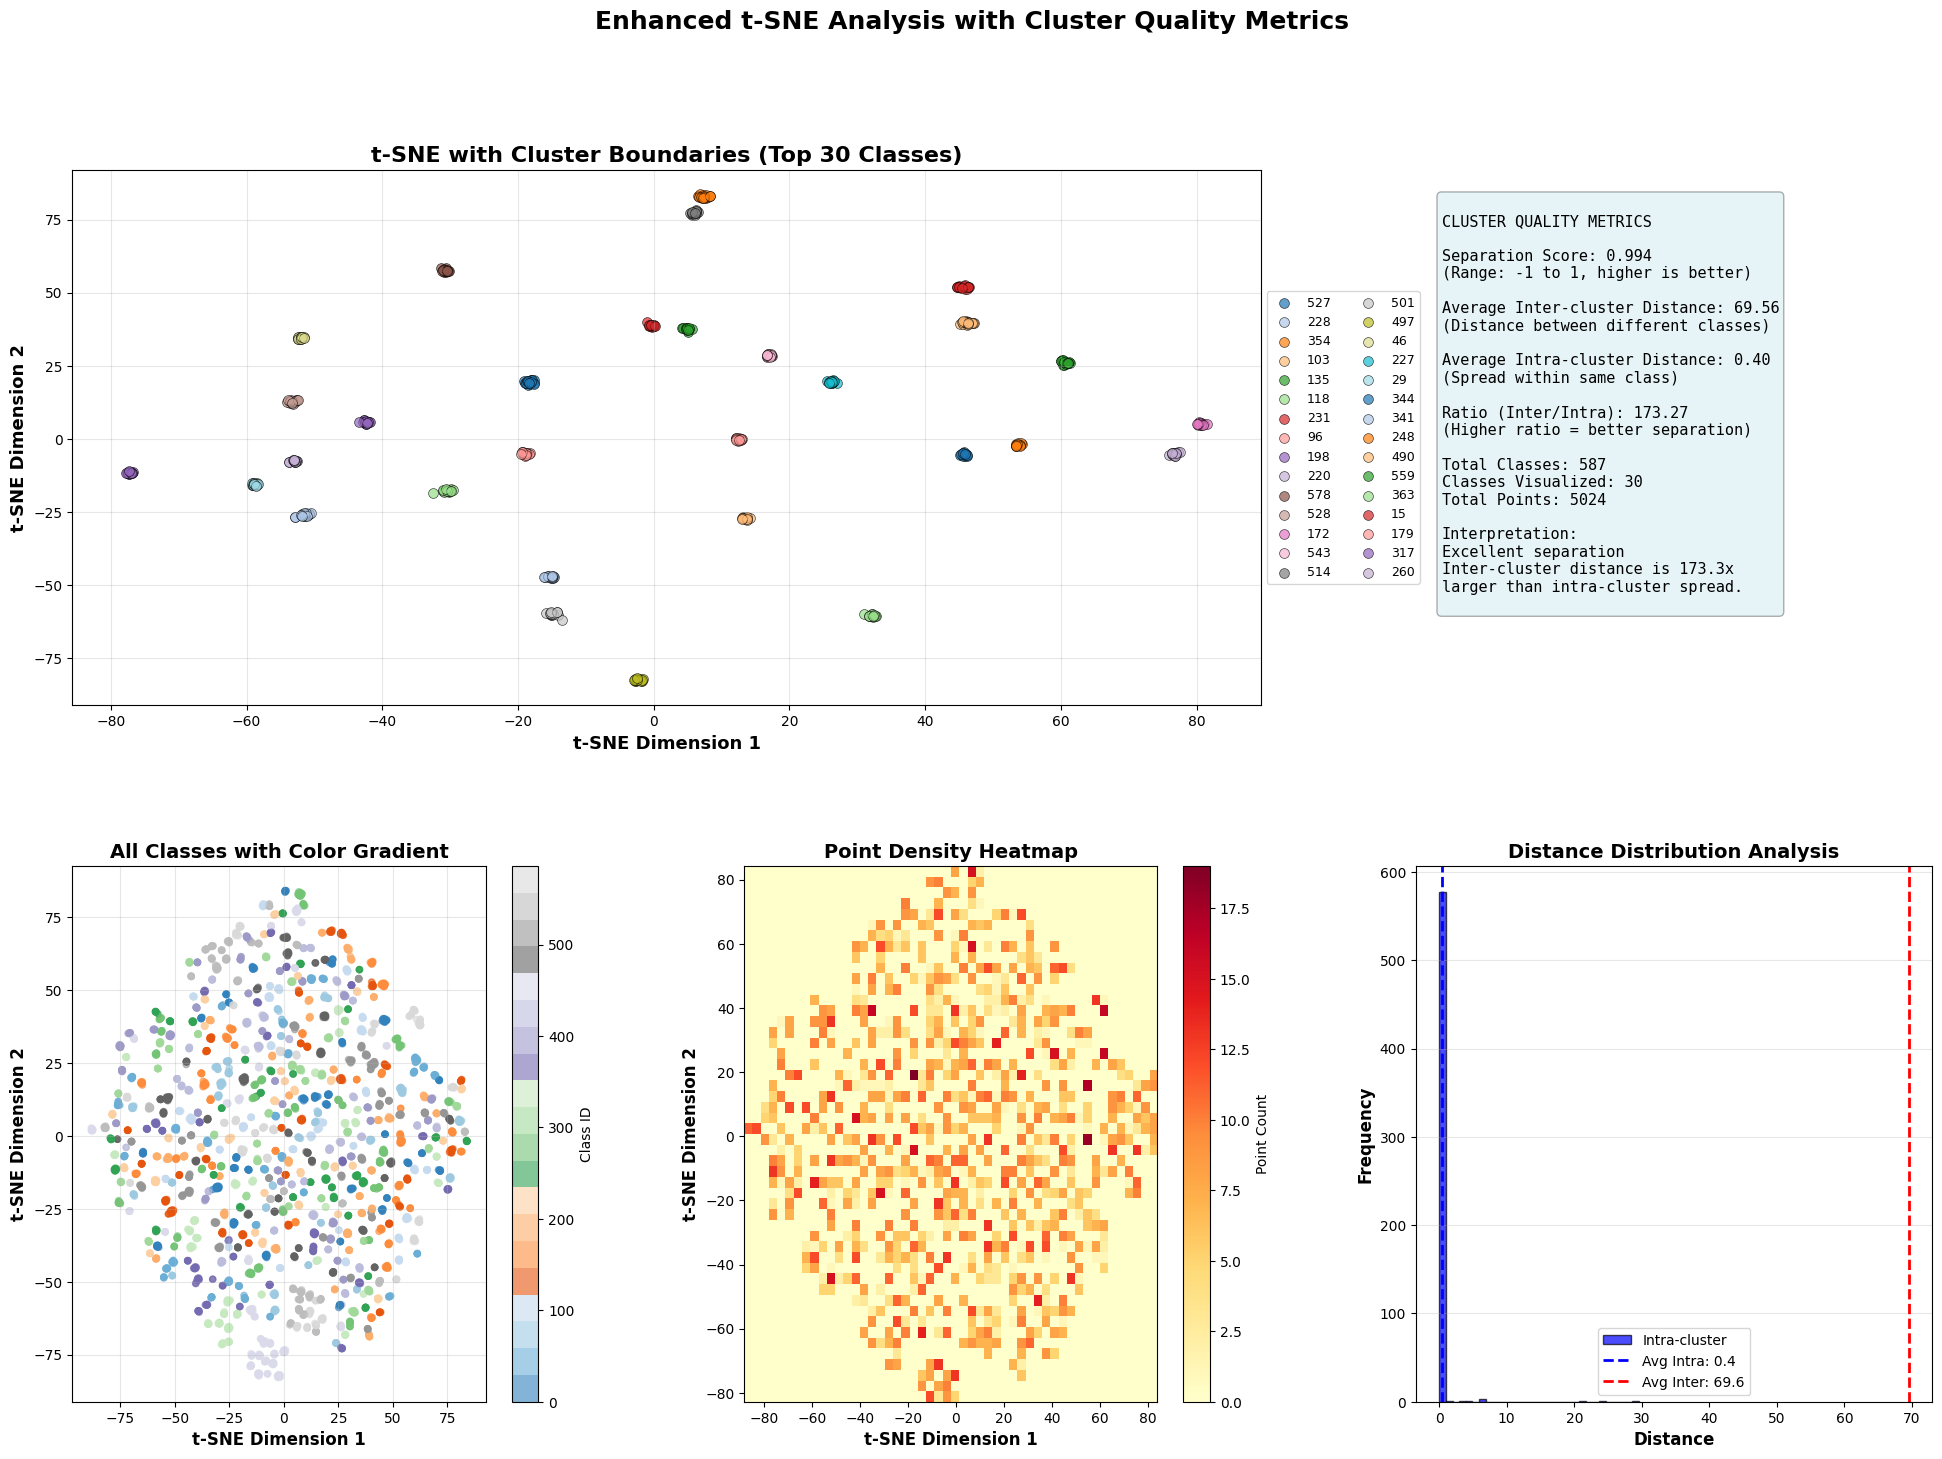


ENHANCED t-SNE ANALYSIS
Separation Score: 0.994
Inter/Intra Ratio: 173.27


In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

# Use existing t-SNE results
tsne_results = swin_metrics['tsne_results']
val_labels = swin_metrics['tsne_labels']

# Create enhanced visualization
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

unique_labels = np.unique(val_labels)
n_classes = len(unique_labels)

# Count samples per class
from collections import Counter
class_counts = Counter(val_labels)
top_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:30]
top_class_ids = [c[0] for c in top_classes]

# ========== Plot 1: Top 30 classes with cluster boundaries ==========
ax1 = fig.add_subplot(gs[0, :2])

colors = plt.cm.tab20(np.linspace(0, 1, 20))
colors = np.vstack([colors, colors])  # 40 colors

for idx, class_id in enumerate(top_class_ids):
    mask = val_labels == class_id
    color = colors[idx % len(colors)]
    
    points = tsne_results[mask]
    ax1.scatter(points[:, 0], points[:, 1], 
               c=[color], s=50, alpha=0.7, edgecolors='black', linewidth=0.5,
               label=f'{dataset.classes[class_id][:10]}')
    
    # Add ellipse showing cluster spread
    if len(points) > 2:
        mean = points.mean(axis=0)
        cov = np.cov(points.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(mean, width, height, angle=angle, 
                         facecolor='none', edgecolor=color, linewidth=2, linestyle='--', alpha=0.5)
        ax1.add_patch(ellipse)

ax1.set_title('t-SNE with Cluster Boundaries (Top 30 Classes)', fontsize=16, fontweight='bold')
ax1.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax1.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9, ncol=2)

# ========== Plot 2: Cluster quality metrics ==========
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')

# Calculate intra-cluster and inter-cluster distances
from scipy.spatial.distance import cdist

intra_distances = []
centroids = {}

for class_id in unique_labels:
    mask = val_labels == class_id
    if mask.sum() > 1:
        points = tsne_results[mask]
        centroids[class_id] = points.mean(axis=0)
        # Average distance to centroid
        dists = np.sqrt(((points - centroids[class_id])**2).sum(axis=1))
        intra_distances.append(dists.mean())

centroid_array = np.array(list(centroids.values()))
inter_distances = cdist(centroid_array, centroid_array)
np.fill_diagonal(inter_distances, np.nan)
avg_inter = np.nanmean(inter_distances)
avg_intra = np.mean(intra_distances)

silhouette_like = (avg_inter - avg_intra) / max(avg_inter, avg_intra)

quality_text = f"""
CLUSTER QUALITY METRICS

Separation Score: {silhouette_like:.3f}
(Range: -1 to 1, higher is better)

Average Inter-cluster Distance: {avg_inter:.2f}
(Distance between different classes)

Average Intra-cluster Distance: {avg_intra:.2f}
(Spread within same class)

Ratio (Inter/Intra): {avg_inter/avg_intra:.2f}
(Higher ratio = better separation)

Total Classes: {n_classes}
Classes Visualized: {len(top_class_ids)}
Total Points: {len(tsne_results)}

Interpretation:
{'Excellent separation' if silhouette_like > 0.5 else 'Good separation' if silhouette_like > 0.3 else 'Moderate separation'}
Inter-cluster distance is {avg_inter/avg_intra:.1f}x 
larger than intra-cluster spread.
"""

ax2.text(0.05, 0.95, quality_text, transform=ax2.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# ========== Plot 3: All points with density contours ==========
ax3 = fig.add_subplot(gs[1, 0])

scatter = ax3.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                     c=val_labels, cmap='tab20c', s=20, alpha=0.6)
ax3.set_title('All Classes with Color Gradient', fontsize=14, fontweight='bold')
ax3.set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
ax3.set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Class ID')

# ========== Plot 4: Density heatmap ==========
ax4 = fig.add_subplot(gs[1, 1])

hist, xedges, yedges = np.histogram2d(tsne_results[:, 0], tsne_results[:, 1], bins=50)
im = ax4.imshow(hist.T, origin='lower', cmap='YlOrRd', aspect='auto',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax4.set_title('Point Density Heatmap', fontsize=14, fontweight='bold')
ax4.set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
ax4.set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax4, label='Point Count')

# ========== Plot 5: Distance distribution ==========
ax5 = fig.add_subplot(gs[1, 2])

ax5.hist(intra_distances, bins=30, alpha=0.7, color='blue', label='Intra-cluster', edgecolor='black')
ax5.axvline(avg_intra, color='blue', linestyle='--', linewidth=2, label=f'Avg Intra: {avg_intra:.1f}')
ax5.axvline(avg_inter, color='red', linestyle='--', linewidth=2, label=f'Avg Inter: {avg_inter:.1f}')
ax5.set_xlabel('Distance', fontsize=12, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax5.set_title('Distance Distribution Analysis', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('Enhanced t-SNE Analysis with Cluster Quality Metrics', fontsize=18, fontweight='bold')
plt.savefig('tsne_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("ENHANCED t-SNE ANALYSIS")
print("="*80)
print(f"Separation Score: {silhouette_like:.3f}")
print(f"Inter/Intra Ratio: {avg_inter/avg_intra:.2f}")
print("="*80)